# 03 Model Response Curves
Learn per-channel spend → conversions relationships using:
- Linear Regression (baseline, interpretable)
- Boosted Trees (HistGradientBoostingRegressor; XGBoost if available)

We’ll export smooth response curves per channel for optimization in Part 5.

In [23]:
# 03 Model Response Curves (with smoothing & version-proof metrics)
# Learns per-channel Spend -> Conversions curves using Linear Regression and XGBoost.
# Exports smoothed curves for the optimizer in Part-5.
# Outputs:
#   ../data/processed/response_curves/<channel>_response_curve.csv
#   ../data/processed/model_response_summary.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

from scipy.signal import savgol_filter

np.set_printoptions(suppress=True)
pd.set_option("display.float_format", "{:,.4f}".format)

DATA_PATH = Path("../data/processed/campaign_daily_processed.csv")
OUT_DIR   = Path("../data/processed/response_curves")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

In [24]:
df = pd.read_csv(DATA_PATH, parse_dates=["date"])
required = {"date","channel","spend","conversions","is_weekend"}
missing = required - set(df.columns)
assert not missing, f"Missing columns in {DATA_PATH}: {missing}"

df = df.sort_values(["channel","date"]).reset_index(drop=True)
channels = df["channel"].unique().tolist()
print("Channels:", channels)
df.head()

Channels: ['Display', 'LinearTV', 'Social', 'Streaming', 'YouTube']


,date,channel,spend,cpm,impressions,clicks,conversions,est_reach,dow,is_weekend,reach_pct,reach_people
0,2024-01-01,Display,"17,034.6002",8.0000,"2,129,325.0204","39,800.7073",16.6882,"193,917.5999",0,0,0.1534,"153,431.4496"
1,2024-01-02,Display,"12,958.5648",8.0000,"1,619,820.5979","32,100.6461",11.7075,"151,922.2405",1,0,0.1196,"119,634.8306"
2,2024-01-03,Display,"15,738.2296",8.0000,"1,967,278.7043","41,406.0910",19.4053,"180,838.5029",2,0,0.1429,"142,868.6928"
3,2024-01-04,Display,"18,866.2482",8.0000,"2,358,281.0262","50,526.8998",15.4489,"211,968.9149",3,0,0.1681,"168,066.8425"
4,2024-01-05,Display,"12,580.8009",8.0000,"1,572,600.1150","31,936.8906",24.9950,"147,898.5584",4,0,0.1164,"116,414.5161"


In [25]:
def make_features(frame: pd.DataFrame) -> pd.DataFrame:
    X = frame.copy()
    X["log_spend"] = np.log1p(X["spend"])
    X["sqrt_spend"] = np.sqrt(X["spend"])
    if "month" not in X:
        X["month"] = pd.to_datetime(X["date"]).dt.month
    return X[["log_spend","sqrt_spend","month","is_weekend"]]

def evaluate(y_true, y_pred) -> dict:
    # Robust to older sklearn: RMSE computed manually
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # default squared=True
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [26]:
def smooth_series(y, max_window=21, poly=2):
    """
    Savitzky–Golay smoothing with safe window selection:
    - window odd
    - window >= 5
    - window <= len(y)
    Falls back to raw y if too short.
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n < 5:
        return y
    w = min(max_window, n)
    if w % 2 == 0:  # must be odd
        w -= 1
    if w < 5:
        # last-resort odd <= n
        w = n if n % 2 == 1 else n-1
        if w < 5:
            return y
    return savgol_filter(y, w, poly, mode="nearest")

Display: LR RMSE=4.861  XGB RMSE=6.429


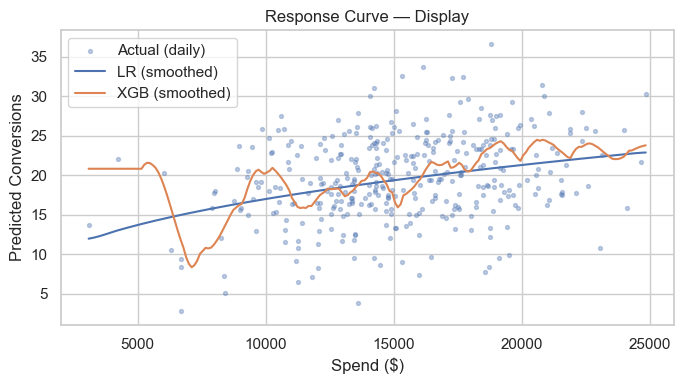

LinearTV: LR RMSE=5.983  XGB RMSE=6.872


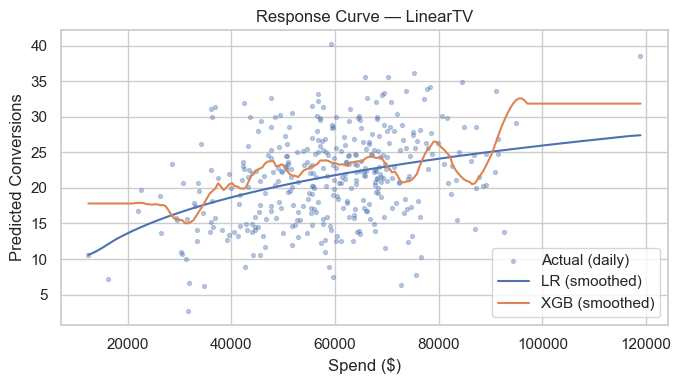

Social: LR RMSE=6.011  XGB RMSE=7.189


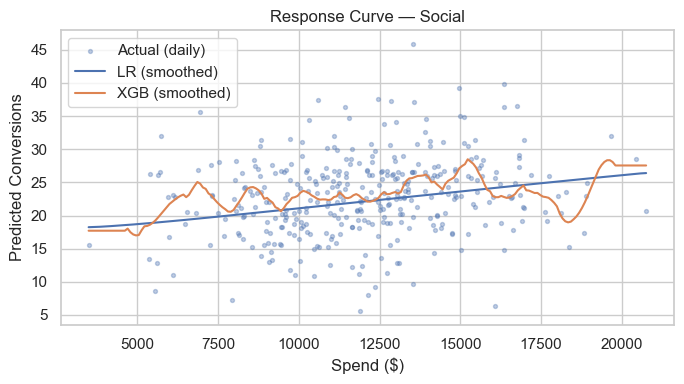

Streaming: LR RMSE=5.073  XGB RMSE=6.015


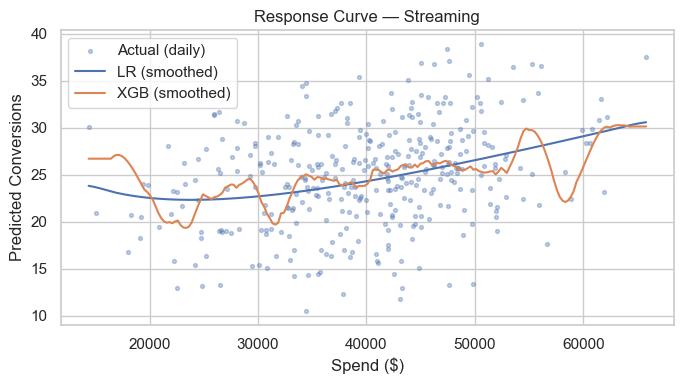

YouTube: LR RMSE=5.016  XGB RMSE=5.735


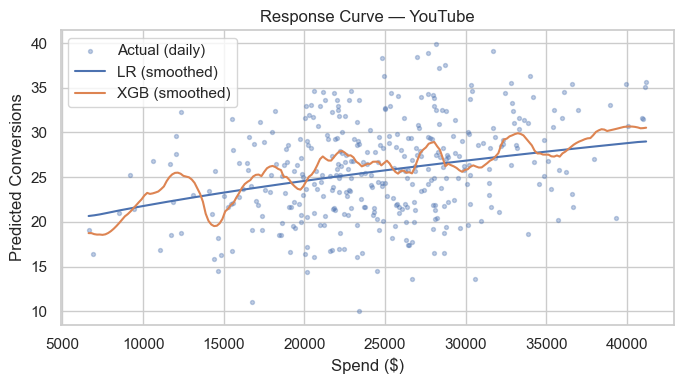

In [27]:
summary_rows = []

for ch in channels:
    sub = df[df["channel"] == ch].copy().sort_values("date").reset_index(drop=True)

    # time-aware split: first 80% train, last 20% test
    n = len(sub)
    cut = max(2, int(n * 0.8))  # guard tiny sets
    train, test = sub.iloc[:cut].copy(), sub.iloc[cut:].copy()

    X_train, y_train = make_features(train), train["conversions"].astype(float)
    X_test,  y_test  = make_features(test),  test["conversions"].astype(float)

    # --- Linear Regression ---
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr_test = lr.predict(X_test)

    # --- XGBoost (nonlinear) ---
    xgb = XGBRegressor(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgb.fit(X_train, y_train)
    y_pred_xgb_test = xgb.predict(X_test)

    # --- Metrics ---
    m_lr  = evaluate(y_test,  y_pred_lr_test)
    m_xgb = evaluate(y_test, y_pred_xgb_test)

    summary_rows.append([
        ch, m_lr["RMSE"], m_lr["MAE"], m_lr["R2"],
        m_xgb["RMSE"], m_xgb["MAE"], m_xgb["R2"]
    ])
    print(f"{ch}: LR RMSE={m_lr['RMSE']:.3f}  XGB RMSE={m_xgb['RMSE']:.3f}")

    # === Build a spend grid over the channel's observed range ===
    smin, smax = float(sub["spend"].min()), float(sub["spend"].max())
    if not np.isfinite(smin) or not np.isfinite(smax) or smax <= smin:
        smin, smax = 1.0, max(2.0, float(sub["spend"].mean())*2)

    grid = np.linspace(smin, smax, 201)
    grid_df = pd.DataFrame({
        "date": pd.Timestamp("2024-06-15"),  # neutral month for consistent features
        "spend": grid,
        "is_weekend": 0
    })
    Xg = make_features(grid_df)

    pred_lr  = np.clip(lr.predict(Xg),  0, None)
    pred_xgb = np.clip(xgb.predict(Xg), 0, None)

    # Smooth to reduce jaggedness and stabilize Part-5 interpolation
    pred_lr_smooth  = smooth_series(pred_lr)
    pred_xgb_smooth = smooth_series(pred_xgb)

    # Export (stable schema for Part-5)
    snake = ch.lower().replace(" ", "").replace("-", "")
    out = pd.DataFrame({
        "spend": grid.astype(float),
        "pred_conversions_xgb": pred_xgb_smooth.astype(float),
        "pred_conversions_lr":  pred_lr_smooth.astype(float)
    }).sort_values("spend").drop_duplicates(subset=["spend"])
    out.to_csv(OUT_DIR / f"{snake}_response_curve.csv", index=False)

    # Optional quick visual (comment out if you prefer silent run)
    plt.figure(figsize=(7,4))
    plt.scatter(sub["spend"], sub["conversions"], s=8, alpha=0.35, label="Actual (daily)")
    plt.plot(grid, pred_lr_smooth,  label="LR (smoothed)")
    plt.plot(grid, pred_xgb_smooth, label="XGB (smoothed)")
    plt.title(f"Response Curve — {ch}")
    plt.xlabel("Spend ($)"); plt.ylabel("Predicted Conversions")
    plt.legend(); plt.tight_layout(); plt.show()

In [8]:
import sys, inspect, sklearn
print("Python:", sys.executable)
print("sklearn:", sklearn.__version__)
print("inspect:", inspect.__file__)

Python: /Users/aravindanisetti/Desktop/2025 Training/Projects/.venv/bin/python
sklearn: 1.7.2
inspect: /usr/local/Cellar/python@3.11/3.11.14/Frameworks/Python.framework/Versions/3.11/lib/python3.11/inspect.py


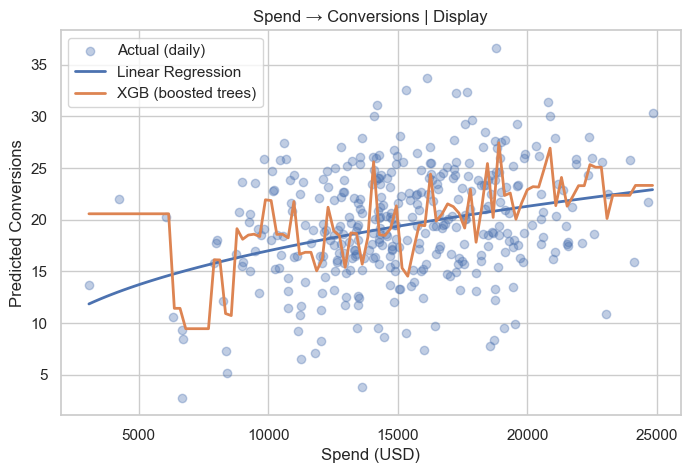

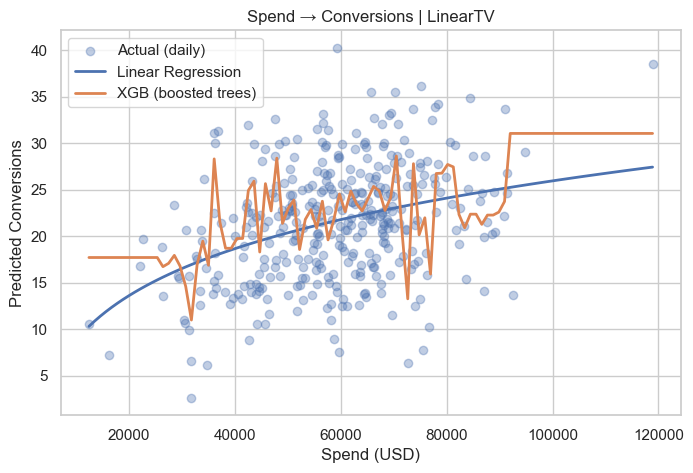

In [9]:
sns.set_theme(style="whitegrid")

def plot_response_curve(channel, month=6, is_weekend=0, num=100):
    sub = df[df["channel"]==channel]
    spend_grid = np.linspace(sub["spend"].min(), sub["spend"].max(), num)
    X_seq = pd.DataFrame({
        "log_spend": np.log1p(spend_grid),
        "sqrt_spend": np.sqrt(spend_grid),
        "month": month,
        "is_weekend": is_weekend
    })
    lr = models[channel]["lr"]
    bt = models[channel]["bt"]
    bt_name = models[channel]["bt_name"]

    pred_lr = lr.predict(X_seq)
    pred_bt = bt.predict(X_seq)

    plt.figure(figsize=(8,5))
    plt.scatter(sub["spend"], sub[TARGET], alpha=0.35, label="Actual (daily)")
    plt.plot(spend_grid, pred_lr, label="Linear Regression", linewidth=2)
    plt.plot(spend_grid, pred_bt, label=f"{bt_name} (boosted trees)", linewidth=2)
    plt.title(f"Spend → Conversions | {channel}")
    plt.xlabel("Spend (USD)")
    plt.ylabel("Predicted Conversions")
    plt.legend()
    plt.show()

# Example plot for two channels
for ch in channels[:2]:
    plot_response_curve(ch)

In [10]:
out_dir = Path("../data/processed/response_curves")
out_dir.mkdir(parents=True, exist_ok=True)

for ch in channels:
    sub = df[df["channel"]==ch]
    spend_grid = np.linspace(sub["spend"].min(), sub["spend"].max(), 120)

    X_seq = pd.DataFrame({
        "log_spend": np.log1p(spend_grid),
        "sqrt_spend": np.sqrt(spend_grid),
        "month": 6,
        "is_weekend": 0
    })

    lr = models[ch]["lr"]
    bt = models[ch]["bt"]
    bt_name = models[ch]["bt_name"]

    out = pd.DataFrame({
        "channel": ch,
        "spend": spend_grid,
        "pred_conversions_lr": lr.predict(X_seq),
        f"pred_conversions_{bt_name.lower()}": bt.predict(X_seq)
    })
    out.to_csv(out_dir / f"{ch.lower()}_response_curve.csv", index=False)

out_dir, list(out_dir.glob("*.csv"))[:3]

(PosixPath('../data/processed/response_curves'),
 [PosixPath('../data/processed/response_curves/social_response_curve.csv'),
  PosixPath('../data/processed/response_curves/youtube_response_curve.csv'),
  PosixPath('../data/processed/response_curves/lineartv_response_curve.csv')])